P2 Project Submission
By Garrett Busch 
Jan 2017

Intro 

Baseball America's golden pasttime. This one sport has truly been a source of entertainment for the USA for generations. Beyond the awe-inspiring athletic feats of athletes like Bonds, Chapman, Jackson lies an advanced sabermetric world full of mathmatical measures to apply. In terms of American sports, Baseball, has always owned virtue to numbers and/or metrics. Ask any baseball fan what "three-hundred" is and they will likely respond with the measure at which a hitter is able to attain a hit in any given at-bat (and to be considered very good at it). With the advent of new technologies such as statcast we are able to analyze this game like its never been done before.

Yet, there is still so much to garner from the information of Baseball's past. One such question, that for me, has always been truly hard to magnify but becomes evident as players ascend the little league ranks to the bigs is 


http://www.billjamesonline.com/article785/

http://pandas.pydata.org/pandas-docs/stable/merging.html

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
plt.style.use('ggplot')
%matplotlib inline

#GHreposit = "https://raw.githubusercontent.com/thrabchak/Udacity-Data-Analysis/"
GHreposit = "https://raw.githubusercontent.com/garrettbusch15/P2-Baseball-Analysis-Project/"
#subfoler = "master/P2%20Baseball%20Managers/data/"
subfolder = "master/Data/"

In [2]:
fair_weather_stats = ['CA','TX','FL','AZ','NV','NM', 'GA', 'LA']

In [3]:
# Shift-Tab to see paramters/help for function
fileMaster = pd.read_csv(GHreposit + subfolder + 'Master.csv')
fileBatting = pd.read_csv(GHreposit + subfolder + 'Batting.csv')
filePitching = pd.read_csv(GHreposit + subfolder + 'Pitching.csv')
fileFielding = pd.read_csv(GHreposit + subfolder + 'Fielding.csv')
fileAppearance = pd.read_csv(GHreposit + subfolder + 'Appearances.csv')
fileSalaries = pd.read_csv(GHreposit + subfolder + 'Salaries.csv')
fileHOF = pd.read_csv(GHreposit + subfolder + 'HallOfFame.csv')
fileAllStart = pd.read_csv(GHreposit + subfolder + 'AllstarFull.csv')
fileManagers = pd.read_csv(GHreposit + subfolder + 'Managers.csv')
fileAwards = pd.read_csv(GHreposit + subfolder + 'AwardsPlayers.csv')

In [4]:
# 1/24/15 is the date of this data's publishing
fileMaster['finalGame'].fillna('1/24/2015', inplace=True)

In [5]:
fileMaster['StateWeather'] = fileMaster['birthState'].map(lambda x: True if x in fair_weather_stats else False)

In [6]:
fileMaster['debut'] = pd.to_datetime(fileMaster['debut'])
fileMaster['finalGame'] = pd.to_datetime(fileMaster['finalGame'])
fileMaster['careerLength'] = fileMaster['finalGame'] - fileMaster['debut']

In [7]:
fileMaster.head(5)

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,weight,height,bats,throws,debut,finalGame,retroID,bbrefID,StateWeather,careerLength
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,205.0,75.0,R,R,2004-04-06,2013-09-28,aardd001,aardsda01,False,3462 days
1,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,180.0,72.0,R,R,1954-04-13,1976-10-03,aaroh101,aaronha01,False,8209 days
2,aaronto01,1939.0,8.0,5.0,USA,AL,Mobile,1984.0,8.0,16.0,...,190.0,75.0,R,R,1962-04-10,1971-09-26,aarot101,aaronto01,False,3456 days
3,aasedo01,1954.0,9.0,8.0,USA,CA,Orange,NaN,NaN,NaN,...,190.0,75.0,R,R,1977-07-26,1990-10-03,aased001,aasedo01,True,4817 days
4,abadan01,1972.0,8.0,25.0,USA,FL,Palm Beach,NaN,NaN,NaN,...,184.0,73.0,L,L,2001-09-10,2006-04-13,abada001,abadan01,True,1676 days


In [8]:
def c_num(s):
    try:
        return float(s)
    except Exception:
        return 0
def f_Avg(AB, H):
    return round(H / AB,3)
def f_Obp(H,BB,IBB,HBP,SF,AB):
    n = (H + BB + HBP)
    d = (AB + BB + HBP + SF)
    return round(n / d,3)
def f_Slug(H, Dbl, Trpl, HR, AB):
    return round(((H - Dbl - Trpl - HR) + (Dbl * 2) + (Trpl * 3) + (HR * 4)) / AB,3)

In [9]:
# Insert common hitting statistics into batting dataframe
fileBatting.fillna(0, inplace=True)
fileBatting['statBA'] = fileBatting.apply(lambda row: f_Avg(row['AB'],row['H']) if row['AB'] != 0 else 0, axis=1)
fileBatting['statOBP'] = fileBatting.apply(lambda row: f_Obp(row['H'],row['BB'],row['IBB'],row['HBP'],row['SF'],row['AB']) if (row['AB']+ row['BB'] + row['HBP'] + row['SF']) != 0 else 0, axis=1)
fileBatting['statSLUG'] = fileBatting.apply(lambda row: f_Slug(row['H'],row['2B'],row['3B'],row['HR'],row['AB']) if row['AB'] != 0 else 0, axis=1)
fileBatting['statOPS+'] = fileBatting['statOBP'] + fileBatting['statSLUG']

In [10]:
stats_to_summarize = {
    # 'G':0,
    # 'AB':0,
    'R':0,
    'H':0,
    '2B':0,
    '3B':0,
    'HR':0,
    'BB':0,
    'RBI':0,
    'SO':0,
    'IBB':0,
    'HBP':0,
    'SH':0,
    'SF':0
    # 'lgAvg':[]
    # 'lgObp':[]
    # 'lgSlug':[]
    # 'lgOps':[]
}

In [11]:
def season_stat_compiliation():
    dicBat = {}
    for year in pd.unique(fileBatting.yearID.ravel()):
        dicBat[year] = season_offense_summary(year)
    return pd.DataFrame(dicBat)

In [12]:
def season_offense_summary(year):
    dicSum = {}
    dicSum['Players'] = len(fileBatting.loc[fileBatting['yearID'] == year])
    dicSum['AB'] = fileBatting.loc[(fileBatting['yearID'] == year), 'AB'].sum()
    dicSum['G'] = fileBatting.loc[(fileBatting['yearID'] == year), 'G'].sum()
    for stat in stats_to_summarize.keys():
        dicSum[stat] = fileBatting.loc[(fileBatting['yearID'] == year), stat].sum()
        dicSum[stat + '_G'] = round(fileBatting.loc[(fileBatting['yearID'] == year), stat].sum() / dicSum['G'],4)
        dicSum[stat + '_AB'] = round(fileBatting.loc[(fileBatting['yearID'] == year), stat].sum() / dicSum['AB'],4)
    dicSum['lgAvg'] = f_Avg(dicSum['H'],dicSum['AB'])
    dicSum['lgObp'] = f_Obp(dicSum['H'],dicSum['BB'],dicSum['IBB'], dicSum['HBP'],dicSum['SF'],dicSum['AB'])
    dicSum['lgSlug'] = f_Slug(dicSum['H'],dicSum['2B'],dicSum['3B'],dicSum['HR'],dicSum['AB'])
    dicSum['lgOps+'] = dicSum['lgObp'] + dicSum['lgSlug']
    
    return dicSum

In [ ]:
def team_offense_summary(year, team):
    dicSum = {}
    dicSum['Players'] = len(fileBatting.loc[(fileBatting['yearID'] == year) & (fileBatting['teamID'] == team)])
    dicSum['AB'] = fileBatting.loc[(fileBatting['yearID'] == year) & (fileBatting['teamID'] == team), 'AB'].sum()
    dicSum['G'] = fileBatting.loc[(fileBatting['yearID'] == year) & (fileBatting['teamID'] == team), 'G'].sum()
    for stat in stats_to_summarize.keys():
        dicSum[stat] = fileBatting.loc[(fileBatting['yearID'] == year) & (fileBatting['teamID'] == team), stat].sum()
        dicSum[stat + '_G'] = round(fileBatting.loc[(fileBatting['yearID'] == year) & (fileBatting['teamID'] == team), stat].sum() / dicSum['G'],4)
        dicSum[stat + '_AB'] = round(fileBatting.loc[(fileBatting['yearID'] == year) & (fileBatting['teamID'] == team), stat].sum() / dicSum['AB'],4)
    dicSum['lgAvg'] = f_Avg(dicSum['H'],dicSum['AB'])
    dicSum['lgObp'] = f_Obp(dicSum['H'],dicSum['BB'],dicSum['IBB'], dicSum['HBP'],dicSum['SF'],dicSum['AB'])
    dicSum['lgSlug'] = f_Slug(dicSum['H'],dicSum['2B'],dicSum['3B'],dicSum['HR'],dicSum['AB'])
    dicSum['lgOps+'] = dicSum['lgObp'] + dicSum['lgSlug']
    
    return dicSum

In [13]:
def create_teammate_relations(Ldf, Rdf):
    return pd.merge(Ldf, Rdf, on='playerID', how='outer')

In [14]:
def f_Obp_Parse(yr, team):
    tmp = x[(x.teamID == team) & (x.yearID == yr)].sum()
    H = tmp['H']
    BB = tmp['BB']
    IBB = tmp['IBB']
    HBP = tmp['HBP']
    SF = tmp['SF']
    AB = tmp['AB']
    return f_Obp(H,BB,IBB,HBP,SF,AB)

In [15]:
stat_summary = season_stat_compiliation()
stat_summary.head(5)

,1871,1872,1873,1874,1875,1876,1877,1878,1879,1880,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
2B,434.0000,567.0000,556.0000,633.0000,839.0000,633.0000,431.0000,481.0000,958.0000,980.0000,...,8863.0000,9135.0000,9197.0000,9014.0000,8737.0000,8486.0000,8399.0000,8261.0000,8222.0000,8137.0000
2B_AB,0.0401,0.0362,0.0328,0.0331,0.0313,0.0315,0.0315,0.0353,0.0397,0.0403,...,0.0533,0.0546,0.0548,0.0541,0.0527,0.0513,0.0507,0.0500,0.0495,0.0491
2B_G,0.1890,0.1715,0.1543,0.1508,0.1343,0.1348,0.1327,0.1449,0.1653,0.1592,...,0.1295,0.1318,0.1311,0.1296,0.1266,0.1231,0.1222,0.1188,0.1187,0.1170
3B,239.0000,139.0000,208.0000,194.0000,273.0000,181.0000,204.0000,132.0000,317.0000,328.0000,...,888.0000,952.0000,938.0000,886.0000,949.0000,866.0000,898.0000,927.0000,772.0000,849.0000
3B_AB,0.0221,0.0089,0.0123,0.0102,0.0102,0.0090,0.0149,0.0097,0.0131,0.0135,...,0.0053,0.0057,0.0056,0.0053,0.0057,0.0052,0.0054,0.0056,0.0046,0.0051


In [16]:
def unique_team_season():
    tms = x[['yearID', 'teamID']].copy()
    tms.drop_duplicates(inplace=True)    
    tms['Teammate_Contribution_OBP'] = tms.apply(lambda w: f_Obp_Parse(w['yearID'],w['teamID']), axis=1)
    return tms

In [17]:
x = create_teammate_relations(fileMaster,fileBatting)
x

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,SO,IBB,HBP,SH,SF,GIDP,statBA,statOBP,statSLUG,statOPS+
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
1,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000,0.000,0.000
2,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
3,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
4,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
5,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
6,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
7,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
8,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,39.0,0.0,3.0,6.0,4.0,13.0,0.280,0.322,0.447,0.769
9,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,61.0,5.0,3.0,7.0,4.0,20.0,0.314,0.366,0.540,0.906


In [18]:
# Career OPS of players of fair-weather states vs not
# f_Obp(H,BB,IBB,HBP,SF,AB)
"Fair weather: " + str(f_Obp(x.groupby('StateWeather')['H'].sum()[1],\
                             x.groupby('StateWeather')['BB'].sum()[1],\
                             x.groupby('StateWeather')['IBB'].sum()[1],\
                             x.groupby('StateWeather')['HBP'].sum()[1],\
                             x.groupby('StateWeather')['SF'].sum()[1],\
                             x.groupby('StateWeather')['AB'].sum()[1]))+\
" Not so Fair weather: " + str(f_Obp(x.groupby('StateWeather')['H'].sum()[0],\
                             x.groupby('StateWeather')['BB'].sum()[0],\
                             x.groupby('StateWeather')['IBB'].sum()[0],\
                             x.groupby('StateWeather')['HBP'].sum()[0],\
                             x.groupby('StateWeather')['SF'].sum()[0],\
                             x.groupby('StateWeather')['AB'].sum()[0]))
#Print "Fair Weather OPS: " + x.loc[x['StateWeather'] == True,'H'].sum() +\
#x.loc[x['StateWeather'] == True,'BB'].sum()+\
#x.loc[x['StateWeather'] == True,'IBB'].sum()+\
#x.loc[x['StateWeather'] == True,'HBP'].sum()+\
#x.loc[x['StateWeather'] == True,'SF'].sum()+\
#x.loc[x['StateWeather'] == True,'AB'].sum()

'Fair weather: 0.332 Not so Fair weather: 0.326'

In [19]:
y = unique_team_season()
y

C:\Program Files\Anaconda3\envs\py27\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in double_scalars


,yearID,teamID,Teammate_Contribution_OBP
0,2004.0,SFN,0.357
1,2006.0,CHN,0.319
2,2007.0,CHA,0.318
3,2008.0,BOS,0.358
4,2009.0,SEA,0.314
5,2010.0,SEA,0.298
6,2012.0,NYA,0.337
7,2013.0,NYN,0.306
8,1954.0,ML1,0.327
9,1955.0,ML1,0.326


In [20]:
#temp = x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])].sum()
#x['Teammate_Contribution_OBP'] = x.apply(lambda row: \
#                                         f_Obp(x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])]['H'].sum()-row['H'], \
#       x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])]['BB'].sum()-row['BB'], \
#       x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])]['IBB'].sum()-row['IBB'], \
#       x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])]['HBP'].sum()-row['HBP'], \
#       x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])]['SF'].sum()-row['SF'], \
#       x[(x.teamID == row['teamID']) & (x.yearID == row['yearID'])]['AB'].sum()-row['AB'] \
#      ) if (row['AB']+ row['BB'] + row['HBP'] + row['SF']) != 0 else 0, axis=1)
#x['Teammate_Contribution_OBP'] = x.apply(lambda row: f_Obp_Parse(row), axis=1)
x

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,...,SO,IBB,HBP,SH,SF,GIDP,statBA,statOBP,statSLUG,statOPS+
0,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
1,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,0.0,0.0,0.000,0.000,0.000,0.000
2,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
3,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
4,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
5,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
6,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
7,aardsda01,1981.0,12.0,27.0,USA,CO,Denver,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
8,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,39.0,0.0,3.0,6.0,4.0,13.0,0.280,0.322,0.447,0.769
9,aaronha01,1934.0,2.0,5.0,USA,AL,Mobile,NaN,NaN,NaN,...,61.0,5.0,3.0,7.0,4.0,20.0,0.314,0.366,0.540,0.906


In [21]:
fileBatting.head(5)

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,SO,IBB,HBP,SH,SF,GIDP,statBA,statOBP,statSLUG,statOPS+
0,abercda01,1871,1,TRO,0,1,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000
1,addybo01,1871,1,RC1,0,25,118.0,30.0,32.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.271,0.295,0.322,0.617
2,allisar01,1871,1,CL1,0,29,137.0,28.0,40.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.292,0.302,0.394,0.696
3,allisdo01,1871,1,WS3,0,27,133.0,28.0,44.0,10.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.331,0.331,0.481,0.812
4,ansonca01,1871,1,RC1,0,25,120.0,29.0,39.0,11.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.325,0.336,0.467,0.803


In [22]:
filePitching.head(5)

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,...,NaN,NaN,NaN,0,NaN,NaN,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,...,NaN,NaN,NaN,0,NaN,NaN,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,...,NaN,NaN,NaN,0,NaN,NaN,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,...,NaN,NaN,NaN,0,NaN,NaN,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,...,NaN,NaN,NaN,0,NaN,NaN,21,NaN,NaN,NaN


In [23]:
fileFielding.head(5)

,playerID,yearID,stint,teamID,lgID,POS,G,GS,InnOuts,PO,A,E,DP,PB,WP,SB,CS,ZR
0,abercda01,1871,1,TRO,NaN,SS,1,NaN,NaN,1.0,3.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN
1,addybo01,1871,1,RC1,NaN,2B,22,NaN,NaN,67.0,72.0,42.0,5.0,NaN,NaN,NaN,NaN,NaN
2,addybo01,1871,1,RC1,NaN,SS,3,NaN,NaN,8.0,14.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN
3,allisar01,1871,1,CL1,NaN,2B,2,NaN,NaN,1.0,4.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,allisar01,1871,1,CL1,NaN,OF,29,NaN,NaN,51.0,3.0,7.0,1.0,NaN,NaN,NaN,NaN,NaN


In [24]:
fileAppearance.head(5)

,yearID,teamID,lgID,playerID,G_all,GS,G_batting,G_defense,G_p,G_c,...,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_of,G_dh,G_ph,G_pr
0,1871,BS1,NaN,barnero01,31.0,NaN,31,31.0,0,0,...,16,0,15,0,0,0,0,NaN,NaN,NaN
1,1871,BS1,NaN,barrofr01,18.0,NaN,18,18.0,0,0,...,1,0,0,13,0,4,17,NaN,NaN,NaN
2,1871,BS1,NaN,birdsda01,29.0,NaN,29,29.0,0,7,...,0,0,0,0,0,27,27,NaN,NaN,NaN
3,1871,BS1,NaN,conefr01,19.0,NaN,19,19.0,0,0,...,0,0,0,18,0,1,18,NaN,NaN,NaN
4,1871,BS1,NaN,gouldch01,31.0,NaN,31,31.0,0,0,...,0,0,0,0,0,1,1,NaN,NaN,NaN


There are many things to discover about this data. Having played baseball and having general awareness to many baseball statistics there a certain "random" which may be of fun fact. For instance, it may be interesting to know who was the best "team-mate" of all time, or maybe how players "peak" years have evolved over time.

Some highlited details that Udacity would like me to look at are the relationship between different metrics, analyzing independent (3) and dependent (1) variables, and the characteristics of players with the highest salaries.

Lets begin..

## A few supporting metrics:

Number of people who have played MLB (from dataset).. 18,589

In [25]:
totplayers = fileMaster.shape[0]

How many different countries have been represented in the MLB?.. 52

In [26]:
fileMaster.groupby(['birthCountry']).size()

birthCountry
Afghanistan           1
American Samoa        1
Aruba                 5
At Sea                1
Australia            28
Austria               4
Bahamas               6
Belgium               1
Belize                1
Brazil                2
CAN                 244
China                 1
Colombia             14
Cuba                191
Curacao              14
Czech Republic        4
D.R.                619
Denmark               1
Finland               1
France                8
Germany              45
Greece                1
Guam                  1
Honduras              1
Indonesia             1
Ireland              50
Italy                 7
Jamaica               4
Japan                61
Lithuania             1
Mexico              114
Netherlands          12
Nicaragua            13
Norway                3
P.R.                246
Panama               53
Philippines           1
Poland                5
Russia                8
Saudi Arabia          2
Singapore             1
Slo

So..

In [27]:
len(fileMaster.groupby(['birthCountry']).size())

52

It seems there maybe some holes in our dataset i.e. players without a birth country..

In [28]:
fileMaster.fillna

<bound method DataFrame.fillna of         playerID  birthYear  birthMonth  birthDay birthCountry birthState  \
0      aardsda01     1981.0        12.0      27.0          USA         CO   
1      aaronha01     1934.0         2.0       5.0          USA         AL   
2      aaronto01     1939.0         8.0       5.0          USA         AL   
3       aasedo01     1954.0         9.0       8.0          USA         CA   
4       abadan01     1972.0         8.0      25.0          USA         FL   
5       abadfe01     1985.0        12.0      17.0         D.R.  La Romana   
6      abadijo01     1854.0        11.0       4.0          USA         PA   
7      abbated01     1877.0         4.0      15.0          USA         PA   
8      abbeybe01     1869.0        11.0      11.0          USA         VT   
9      abbeych01     1866.0        10.0      14.0          USA         NE   
10     abbotda01     1862.0         3.0      16.0          USA         OH   
11     abbotfr01     1874.0        10.0   

In [29]:
fileMaster.groupby(['birthCountry']).size()

birthCountry
Afghanistan           1
American Samoa        1
Aruba                 5
At Sea                1
Australia            28
Austria               4
Bahamas               6
Belgium               1
Belize                1
Brazil                2
CAN                 244
China                 1
Colombia             14
Cuba                191
Curacao              14
Czech Republic        4
D.R.                619
Denmark               1
Finland               1
France                8
Germany              45
Greece                1
Guam                  1
Honduras              1
Indonesia             1
Ireland              50
Italy                 7
Jamaica               4
Japan                61
Lithuania             1
Mexico              114
Netherlands          12
Nicaragua            13
Norway                3
P.R.                246
Panama               53
Philippines           1
Poland                5
Russia                8
Saudi Arabia          2
Singapore             1
Slo

Of the USA players how many states have been represented?.. 51 (All + DC included)

In [30]:
fileMaster[(fileMaster['birthCountry'] == 'USA')].groupby(['birthState']).size()

birthState
AK      11
AL     321
AR     152
AZ      99
CA    2115
CO      88
CT     204
DC     101
DE      54
FL     469
GA     338
HI      39
IA     217
ID      28
IL    1051
IN     368
KS     210
KY     278
LA     245
MA     660
MD     310
ME      78
MI     430
MN     163
MO     601
MS     198
MT      24
NC     394
ND      16
NE     112
NH      53
NJ     426
NM      28
NV      35
NY    1202
OH    1030
OK     254
OR     125
PA    1414
RI      77
SC     175
SD      37
TN     293
TX     873
UT      38
VA     283
VT      38
WA     189
WI     244
WV     120
WY      14
dtype: int64

In [31]:
len(fileMaster[(fileMaster['birthCountry'] == 'USA')].groupby(['birthState']).size())

51

What % of players have become deceased?.. ~50%

In [32]:
fileMaster.groupby(['deathYear']).size().sum() / totplayers

0

Heaviest/Lightest/Tallest/Shortest reported player ever?

In [33]:
fileMaster.loc[fileMaster['weight'].argmax(),'nameGiven'] + " " + fileMaster.loc[fileMaster['weight'].argmax(),'nameLast'] + " @ " + str(fileMaster['weight'].max())

'Walter Ernest Young @ 320.0'

In [34]:
fileMaster.loc[fileMaster['weight'].argmin(),'nameGiven'] + " " + fileMaster.loc[fileMaster['weight'].argmin(),'nameLast'] + " @ " + str(fileMaster['weight'].min())

'Edward Carl Gaedel @ 65.0'

In [35]:
fileMaster.loc[fileMaster['height'].argmax(),'nameGiven'] + " " + fileMaster.loc[fileMaster['height'].argmax(),'nameLast'] + " @ " + str(fileMaster['height'].max())

'Jon Erich Rauch @ 83.0'

In [36]:
fileMaster.loc[fileMaster['height'].argmin(),'nameGiven'] + " " + fileMaster.loc[fileMaster['height'].argmin(),'nameLast'] + " @ " + str(fileMaster['height'].min())

'Edward Carl Gaedel @ 43.0'

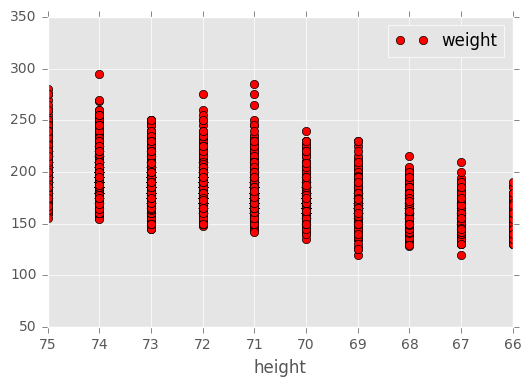

In [37]:
fileMaster.plot(x='height', y='weight', style='ro')

Now lets get to some of these baseball stats. 

Max HRs per year

In [38]:
#fileBatting.groupby('yearID')['HR'].max()

Interesting, and how about something arbitrary, ABs?

In [39]:
#fileBatting.groupby('yearID')['AB'].max()

Lets flip to the defensive side of the ball.

By year, by position, average

In [40]:
#fileFielding.groupby('yearID').groups

Creating a teammate relations table

Example: playerID: {
                    yearID: {
                             teammates playerID: 
                   }        }